# Examples for the Vector Space Model
## Creating our example corpus and query

In [1]:
import pandas as pd

In [2]:
document_1 = ["information", "information", "information", "information", "information", "information", "information", "retrieval", "retrieval"]
document_2 = ["vector", "vector", "vector", "retrieval"]
document_3 = ["vector", "vector", "retrieval", "retrieval", "retrieval", "retrieval"]
corpus = [document_1, document_2, document_3]

query = ['information', 'retrieval', 'vector', 'vector']

Transform the documents and the query into their raw frequency vectors:

In [3]:
def create_vector(document, words):
    return [document.count(word) for word in words]

words = document_1 + document_2 + document_3
unique_words = set(words)
vectors = [create_vector(document, unique_words) for document in corpus] + [create_vector(query, unique_words)]
query_vector = vectors[len(vectors)-1]

# term-document matrix
df_vectors = pd.DataFrame(vectors, ['document_' + str(i + 1) for i in range(len(corpus))] + ['query'], [word for word in unique_words])
df_vectors

,information,retrieval,vector
document_1,7,2,0
document_2,0,1,3
document_3,0,4,2
query,1,1,2


Transform the documents and the query into their tf-idf vectors:

In [4]:
# from tokenized back to raw strings
transformed_corpus = [' '.join(document) for document in corpus]
transformed_query = ' '.join(query)

In [5]:
# use library to create sparse tf_idf vectors for the corpus
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(transformed_corpus)

# tolist() to transform into list with usual python floats
vectors_tf_idf = [document.tolist()[0] for document in tf_idf.todense()]
query_vector_tf_idf = [document.tolist()[0] for document in vectorizer.transform([transformed_query]).todense()][0]

tf_idf_vectors = vectors_tf_idf + [query_vector_tf_idf]

# tf-idf term document matrix
df_tf_idf_vectors = pd.DataFrame(tf_idf_vectors, ['document_' + str(i + 1) for i in range(len(corpus))] + ['query'], [word for word in unique_words])
df_tf_idf_vectors

,information,retrieval,vector
document_1,0.986059,0.166395,0.000000
document_2,0.000000,0.250603,0.968090
document_3,0.000000,0.840802,0.541343
query,0.522535,0.308618,0.794803


## Visualising our vector space

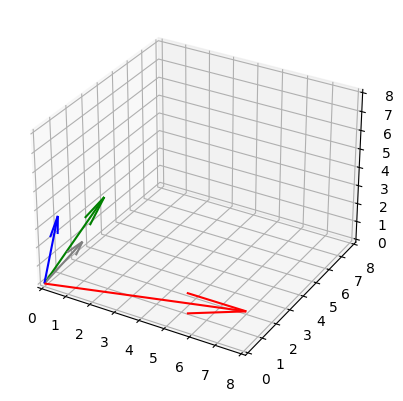

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# red: document_1, blue: document_2, green: document_3, gray: query
plot_vectors = [np.array(vector) for vector in vectors]
colors = ['red', 'blue', 'green', 'gray']

fig = plt.figure()
ax = plt.axes(projection = "3d")

# start from origin
start = [0,0,0]

# vector is defined by origin and the end point
for index in range(len(plot_vectors)):
    ax.quiver(start[0], start[1], start[2], plot_vectors[index][0], plot_vectors[index][1], plot_vectors[index][2], color=colors[index])

ax.set_xlim([0,8])
ax.set_ylim([0,8])
ax.set_zlim([0,8])

plt.show()

## Calculating similarities
### Definition of necessary functions

The dot product of two vectors is: $\sum_{i=1}^{n}value_{ij} * value_{iq}$

In [7]:
# dot product
def calculate_dot(vectors, query_vector):
    dot_results = []

    for index in range(len(vectors) - 1):
        dot_results.append(np.dot(query_vector, vectors[index]))

    return dot_results

The cosine similarity of two vectors is: $\frac{\sum_{i=1}^{n}value_{ij} * value_{iq}}{\sqrt{\sum_{i=1}^{n}value_{ij}^2 * \sum_{i=1}^{n}value_{iq}^2}}$

In [8]:
import math

def calculate_length(vector):
    # sqrt(sum of values²)
    return math.sqrt(sum([value*value for value in vector]))

# cosine
def calculate_cosine(vectors, query_vector):
    cosine_results = []

    query_length = calculate_length(query_vector)
    for index in range(len(vectors) - 1):
        cosine_results.append( round((np.dot(query_vector, vectors[index])) / (query_length * calculate_length(vectors[index])), 2) )

    return cosine_results

### Raw Frequency

In [9]:
dot = calculate_dot(vectors, query_vector)
cosine = calculate_cosine(vectors, query_vector)

df_results_frequency = pd.DataFrame([(dot[i], cosine[i]) for i in range(len(dot))], ['document_' + str(i + 1) for i in range(len(corpus))], ['dot', 'cosine'])
df_results_frequency

,dot,cosine
document_1,9,0.50
document_2,7,0.90
document_3,8,0.73


### TF-IDF

In [10]:
dot_tf_idf = calculate_dot(tf_idf_vectors, query_vector_tf_idf)
cosine_tf_idf = calculate_cosine(tf_idf_vectors, query_vector_tf_idf)

df_results_tf_idf = pd.DataFrame([(round(dot_tf_idf[i], 2), round(cosine_tf_idf[i], 2)) for i in range(len(dot_tf_idf))], ['document_' + str(i + 1) for i in range(len(corpus))], ['dot', 'cosine'])
df_results_tf_idf

,dot,cosine
document_1,0.57,0.57
document_2,0.85,0.85
document_3,0.69,0.69
